In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
import matplotlib.pyplot as plt
import os
from shapely.geometry import LineString, Polygon, Point
from shapely.ops import cascaded_union
import pickle
import math
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap
from dateutil.parser import parse
import matplotlib.patches as plt_patch
from sklearn.neighbors import KDTree
import time
%matplotlib inline

## Convert Sector Geometries

In [2]:
TRACON = pd.read_csv(os.getcwd() + '/TMI/Geometry/TRACON.csv')
SECTOR = pd.read_csv(os.getcwd() + '/TMI/Geometry/SECTOR.csv', usecols=[0,1,2,3,7,8,9,10,11,12,13,14])
SECTOR_MAP = pd.read_csv(os.getcwd() + '/TMI/MAP_Value/SECTOR_MAP.csv')

In [3]:
SECTOR_MAP['SECTOR_NAME'] = SECTOR_MAP['CENTER'] + SECTOR_MAP['SECTOR'].map('{:02}'.format)
SECTOR_MAP.head(2)

,CENTER,SECTOR,MAP,SECTOR_NAME
0,ZSE,1,15,ZSE01
1,ZSE,2,15,ZSE02


In [4]:
# Convert TRACON/SECTOR into single polygon, with name unique
def GetPolygon(x):
    BoundaryCoords = map(float,x.split())
    Poly = Polygon(zip(BoundaryCoords[1::2], BoundaryCoords[0::2]))
    if Poly.is_valid:
        return Poly
    else:
        mlon = 2 * sum(BoundaryCoords[1::2])/len(BoundaryCoords)
        mlat = 2 * sum(BoundaryCoords[0::2])/len(BoundaryCoords)
        def algo(x):
            return (math.atan2(x[0] - mlon, x[1] - mlat) + 2 * math.pi) % (2*math.pi)
        MeterPntList = zip(BoundaryCoords[1::2], BoundaryCoords[0::2])
        MeterPntList.sort(key=algo)
        return Polygon(MeterPntList)

In [5]:
# SECTOR
SECTOR['SECTOR_NAME'] = SECTOR['CENTER'] + SECTOR['SECTOR'].map("{:02}".format)
SECTOR['geometry'] = SECTOR.BOUNDARY.apply(lambda x: GetPolygon(x))
SECTOR_POLY = SECTOR.groupby('SECTOR_NAME').geometry.apply(lambda x: cascaded_union(x)).reset_index()
# TRACON
TRACON['geometry'] = TRACON.BOUNDARY.apply(lambda x: GetPolygon(x))
TRACON_POLY = TRACON.groupby('TRACON_ID').geometry.apply(lambda x: cascaded_union(x)).reset_index()
# ARTCC
ARTCC_POLY = gpd.GeoDataFrame.from_file(os.getcwd()+'/ARTCC/artcc_cont.shp')[['Name','geometry']]
ARTCC_POLY['Name'] = ARTCC_POLY['Name'].apply(lambda x: str(x[-3:]))
# Rename
SECTOR_POLY.columns = ['NAME', 'geometry']
TRACON_POLY.columns = ['NAME', 'geometry']
ARTCC_POLY.columns = ['NAME', 'geometry']
# Paste
facility_poly = SECTOR_POLY.append(ARTCC_POLY).append(TRACON_POLY)

Self-intersection at or near point -104.50136454475793 33.950213195171727
Self-intersection at or near point -110.76984457018492 32.186113388806703
Self-intersection at or near point -103.33465463530135 35.300352216363649


In [6]:
facility_poly.head(2)

,NAME,geometry
0,ZAB15,"POLYGON ((-101.75 36.5, -101.472222 36.397222,..."
1,ZAB16,"POLYGON ((-107.466667 36.2, -106.35 36.626944,..."


In [7]:
# SECTOR_MAP_GEO = SECTOR_MAP.merge(SECTOR_POLY, left_on='SECTOR_NAME', right_on='SECTOR_NAME', how = 'left')

## Load MAP Alert Data/ Get 2013/ Merge w. Polygon

In [8]:
MAP_data = pd.read_csv(os.getcwd() + '/TMI/MAP_VALUE/MA_DATA_2013-2015.csv', usecols = [0,1,2,3,4,5,6], parse_dates=[2,6])
MAP_data['start_year'] = MAP_data.ALERTTIME.apply(lambda x: x.year)
MAP_data['end_year'] = MAP_data.STOPTIME.apply(lambda x: x.year)

In [9]:
MAP_data_2013 = MAP_data[(MAP_data.start_year == 2013) & (MAP_data.end_year == 2013)].reset_index(drop = 1)
print(MAP_data_2013.shape)

(21244, 9)


In [14]:
MAP_data[~MAP_data.SECTOR.isin(facility_poly.NAME)].to_csv('ThrownMAs.csv',index = False)

In [16]:
MAP_2013_GEO = MAP_data_2013.merge(facility_poly, left_on='SECTOR', right_on='NAME', how = 'inner').reset_index(drop = 1)
MAP_2013_GEO.head(2)

,ENTRYID,SECTOR,ALERTTIME,ALERT_TYPE,AREANOTIFIED,POSCNFG,STOPTIME,start_year,end_year,NAME,geometry
0,188551854,ZMP18,2013-01-01 00:15:00,RED,Y,Combined,2013-01-01 00:30:00,2013,2013,ZMP18,"POLYGON ((-97.046111 43.3275, -95.597778000000..."
1,188559808,ZMP18,2013-01-01 15:45:00,RED,Y,Combined,2013-01-01 16:15:00,2013,2013,ZMP18,"POLYGON ((-97.046111 43.3275, -95.597778000000..."


In [17]:
pickle.dump(MAP_2013_GEO, open(os.getcwd() + '/TMI/MAP_VALUE/MA2013_GEO.p', 'wb'), protocol = 2)

## Start New Session

In [12]:
MAP_2013_GEO = pickle.load(open(os.getcwd() + '/TMI/MAP_VALUE/MA2013_GEO.p', 'rb'))

In [15]:
MAP_2013_GEO.shape

(19871, 11)

In [76]:
sector_MA_count = MAP_2013_GEO.groupby(['SECTOR'])['ENTRYID'].count().sort_values(ascending = False).reset_index()

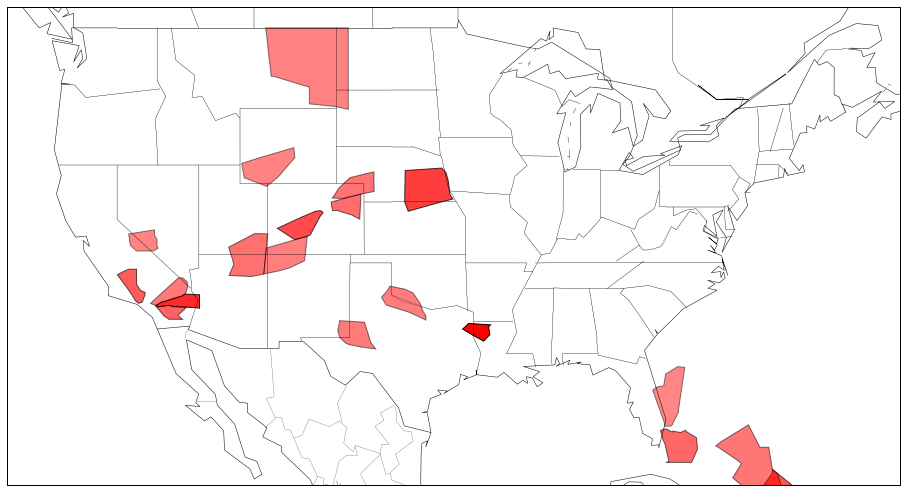

In [77]:
plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = -128, llcrnrlat = 22.5, urcrnrlon = -63, urcrnrlat = 50, projection='merc')
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.2)


for idx, map_single in enumerate(sector_MA_count.head(20).merge(facility_poly, left_on = 'SECTOR', right_on = 'NAME').values):
    coords = np.array(map_single[-1].boundary.coords)
    x,y = m(coords[:,0], coords[:,1])
    xy = zip(x,y)
#     if map_single[1] == 'RED':
    map_Poly = plt_patch.Polygon( xy, facecolor='red', alpha=np.sqrt(np.sqrt(1/(idx+1))))
    plt.gca().add_patch(map_Poly)
#     else:
#         map_Poly = plt_patch.Polygon( xy, facecolor='y', alpha=np.sqrt(np.sqrt(1/(idx+1))))
#         plt.gca().add_patch(map_Poly)

In [9]:
def VisualizeMAP(MAP, alert_start = '01/01/2013 00:00:00', alert_end = '01/01/2013 12:00:30'):
    visual_map = MAP[(MAP.ALERTTIME >= parse(alert_start)) & (MAP.ALERTTIME <= parse(alert_end))][['ALERT_TYPE', 'geometry', 'SECTOR','ENTRYID']]
    print('Total number of MAP: %d' %visual_map.shape[0])
    m = Basemap(llcrnrlon = -128, llcrnrlat = 22.5, urcrnrlon = -63, urcrnrlat = 50, projection='merc')
    m.bluemarble()
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.5)
    m.drawstates(linewidth=0.2)
    m.drawparallels(np.arange(10.,35.,5.))
    m.drawmeridians(np.arange(-120.,-80.,10.))
    
    for idx, map_single in enumerate(visual_map.values):
        if map_single[1].type == 'Polygon':
            coords = np.array(map_single[1].boundary.coords)
            x,y = m(coords[:,0], coords[:,1])
            xy = zip(x,y)
            if map_single[0] == 'RED':
                map_Poly = plt_patch.Polygon( xy, facecolor='red', alpha=0.9)
            else:
                map_Poly = plt_patch.Polygon( xy, facecolor='yellow', alpha=0.9)
            plt.gca().add_patch(map_Poly)
        elif map_single[1].type == 'MultiPolygon':
            for single_poly in map_single[1]:
                coords = np.array(single_poly.boundary.coords)
                x,y = m(coords[:,0], coords[:,1])
                xy = zip(x,y)
                if map_single[0] == 'RED':
                    map_Poly = plt_patch.Polygon( xy, facecolor='red', alpha=0.9)
                else:
                    map_Poly = plt_patch.Polygon( xy, facecolor='yellow', alpha=0.9)
                plt.gca().add_patch(map_Poly)
    return visual_map

Total number of MAP: 53


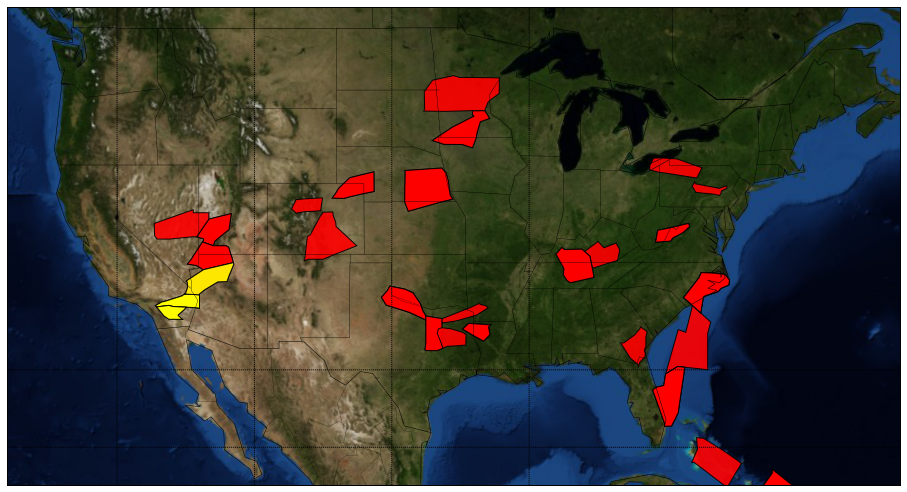

In [10]:
plt.figure(figsize=(16,12))
Visual_Map = VisualizeMAP(MAP_2013_GEO, alert_start = '2/7/2013 00:00:00', alert_end = '2/7/2013 23:59:59')

In [11]:
MAP_2013_GEO.head(1)

,ENTRYID,SECTOR,ALERTTIME,ALERT_TYPE,AREANOTIFIED,POSCNFG,STOPTIME,start_year,end_year,NAME,geometry
0,188551854,ZMP18,2013-01-01 00:15:00,RED,Y,Combined,2013-01-01 00:30:00,2013,2013,ZMP18,"POLYGON ((-97.046111 43.3275, -95.597778000000..."


## Match with MA

In [7]:
class MappingMAP:
    def __init__(self, Dep, Arr, Year, MA_Geo, Type = 'Nominal'):
        # load data
        self.Dep = Dep
        self.Arr = Arr
        self.Year = Year
        self.Type = Type
        VTrackPath = os.getcwd() + '/TFMS_NEW/New_' + Dep + Arr + str(Year) + '.csv'
        VTrack = pd.read_csv(VTrackPath, parse_dates=[6])
        self.LabelData = pd.read_csv(os.getcwd() + '/TFMS_NEW/Label_' + Dep+'_' + Arr+ '_' + str(Year) + '.csv', parse_dates=[6])
        self.CenterTraj = VTrack[VTrack.FID.isin(self.LabelData[self.LabelData.MedianID != -2].FID.values)].reset_index(drop = 1)
        self.CenterFlightID = self.CenterTraj.FID.unique()
        self.MAP = MA_Geo[['ENTRYID', 'ALERTTIME', 'STOPTIME', 'ALERT_TYPE', 'geometry']] 
        # notice the order of the column is different from the original MAP_2013_GEO data
        
        # Convert Geometry, Build trees
        self.Traj_Line, self.Traj_Tree = self.ConvertGeometry()
        self.Mapping_result = {}
        
    def ProcessMIT(self):
        return
    
    def ConvertGeometry(self):
        # Convert coordinates into linestrings
        # Build a tree
        Traj_Line = {}
        Traj_Tree = {} # 2d dictionary. {tree, DT np array}
        for fid in self.CenterTraj.FID.unique():
            traj_coords = np.array(zip(self.CenterTraj[self.CenterTraj.FID == fid].Lon, self.CenterTraj[self.CenterTraj.FID == fid].Lat))
            Traj_Line[fid] = LineString(traj_coords)
            Traj_Tree[fid] = [KDTree(traj_coords), self.CenterTraj[self.CenterTraj.FID == fid].DT.cumsum().values]
        return Traj_Line, Traj_Tree
    
    def MatchMAP(self, departure, Trajectory, Traj_KDtree, MA):
        # Trajectory should be a LineString
        # TrajID should be the FID of the matching Trajectory (center)
        # MA should be a np array containing ENTRYID, ALERTTIME, STOPTIME, ALERT_TYPE, geometry
        if MA[3] == 'RED':
            alert = 2
        else:
            alert = 1
        try:
            # intersection returns the line segment within the polygon
            EntryPt = Trajectory.intersection(MA[4]).coords[0][:2] # entry point
            ExitPt = Trajectory.intersection(MA[4]).coords[-1][:2] # exit point
        except:
            return (0,0,0)
        
        CrossPt_Combine = np.array((EntryPt, ExitPt))
        # find two closest points (index) for entry/ exit point
        nearestidx = Traj_KDtree[0].query(CrossPt_Combine, k = 2)[1]
        # Use the average of the time of the two closest points for entry point as the crossing time
        Entry_DeltaSec = np.mean(Traj_KDtree[1][nearestidx[0]])
        Exit_DeltaSec = np.mean(Traj_KDtree[1][nearestidx[1]])
        
        EntryTime = departure + datetime.timedelta(seconds = Entry_DeltaSec)
        ExitTime = departure + datetime.timedelta(seconds = Exit_DeltaSec)
        
        if EntryTime < MA[2] and ExitTime > MA[1]:
            # Entry time should be earlier than ALERT STOP TIME and exit time should be later than ALERT START TIME
            TraverseTime = abs(Exit_DeltaSec - Entry_DeltaSec)
            return (MA[0], TraverseTime, alert)
        else:
            return (0,0,0)
        
    def Main(self):
        
        Airborne = self.CenterTraj.groupby('FID').DT.sum() # seconds
        st = time.time()
        for i in range(self.LabelData.shape[0]):
            if i % 500 == 0:
                print(i, time.time() - st)
    
            departureTime = self.LabelData.loc[i, 'Elap_Time']
            FFID = self.LabelData.loc[i, 'FID']
            self.Mapping_result[FFID] = {}
            
            for fid in self.CenterFlightID:
                EndTime = departureTime + datetime.timedelta(seconds = Airborne.loc[fid])
                ValidMAP = self.MAP[(self.MAP.ALERTTIME < EndTime) & (self.MAP.STOPTIME > departureTime)]
                if ValidMAP.shape[0] == 0:
                    self.Mapping_result[FFID][fid] = np.array([[0,0,0]])
                else:
                    self.Mapping_result[FFID][fid] = []
                    for idx, MA in enumerate(ValidMAP.values):
                        self.Mapping_result[FFID][fid].append(self.MatchMAP(departureTime, self.Traj_Line[fid], self.Traj_Tree[fid], MA))
                    self.Mapping_result[FFID][fid] = np.array(list(set(self.Mapping_result[FFID][fid])))
        return self.Mapping_result
    
    def Count_Max_MA(self):
        max_ma = 0
        k = 0 # nonzero MA traj.
        for FFID in self.Mapping_result.keys():
            if self.Type == 'Nominal':
                for fid in self.Mapping_result[FFID].keys():
                    count_ma = np.count_nonzero(self.Mapping_result[FFID][fid][:,0])
                    if count_ma != 0:
                        k += 1
                    if count_ma > max_ma:
                        max_ma = count_ma
                    else:
                        pass
            else:
                count_ma = np.count_nonzero(self.Mapping_result[FFID][:,0])
                if count_ma != 0:
                    k += 1
                if count_ma > max_ma:
                    max_ma = count_ma
                else:
                    pass
        return max_ma, k
    
    def ConvertToDataFrame(self):
        if self.Type == 'Nominal':
            df = []
            for FFID in self.Mapping_result:
                for fid in self.Mapping_result[FFID]:
                    summary_stat = [0,0,0,0,0,0]
                    summary_stat[0] = FFID
                    summary_stat[1] = fid
                    summary_stat[2] = np.count_nonzero(self.Mapping_result[FFID][fid][:,2] == 2)
                    summary_stat[3] = np.count_nonzero(self.Mapping_result[FFID][fid][:,2] == 1)
                    summary_stat[4] = np.mean(self.Mapping_result[FFID][fid][:,1][np.where(self.Mapping_result[FFID][fid][:,2]==2)])
                    summary_stat[5] = np.mean(self.Mapping_result[FFID][fid][:,1][np.where(self.Mapping_result[FFID][fid][:,2]==1)])
                    df.append(summary_stat)
            df = np.array(df)
            df[np.isnan(df)] = 0

            data_df = pd.DataFrame(data = df, columns=['FFID','FID_Cluster','NumRed','NumYellow','AvgTimeRed','AvgTimeYellow'])

            data_df.astype(dtype = {'FFID':'int64','FID_Cluster':'int64','NumRed':'int','NumYellow':'int','AvgTimeRed':'float','AvgTimeYellow':'float'})
        else:
            print('Actual type is under development')
        return data_df
    
    def MergeWithMNL(self, SAVE = False):
        # Only work for Nominal now...
        MA_MAP_DF = self.ConvertToDataFrame()
        MNL_data_withWind = pd.read_csv(os.getcwd() + '/MNL/Final_MNL_' + self.Dep + self.Arr + '_' + str(self.Year) +'.csv')
        MNL_data_withWind = MNL_data_withWind.merge(MA_MAP_DF, left_on=['FID_Member','FID_x'], right_on = ['FFID','FID_Cluster'],how='left')
        MNL_data_withWind[['NumRed','NumYellow','AvgTimeRed','AvgTimeYellow']] = \
            MNL_data_withWind[['NumRed','NumYellow','AvgTimeRed','AvgTimeYellow']].fillna(0)
        MNL_data_withWind = MNL_data_withWind.drop(['FFID','FID_Cluster'], axis = 1)
        if SAVE:
            MNL_data_withWind.to_csv(os.getcwd() + '/MNL/MA_Final_MNL_' + self.Dep + self.Arr + '_' + str(self.Year) +'.csv')
        return MNL_data_withWind

In [138]:
Dep = 'IAH'
Arr = 'BOS'
Year = 2013
test = MappingMAP(Dep, Arr, Year, MAP_2013_GEO)

In [139]:
test_result = test.Main()

(0, 0.0)
(500, 14.266999959945679)
(1000, 28.467999935150146)
(1500, 42.34599995613098)


In [140]:
test_count = test.Count_Max_MA()

In [141]:
MNL_data = test.MergeWithMNL()

In [150]:
MNL_data.to_csv(os.getcwd() + '/MNL/MA_Final_MNL_IAHBOS_2013.csv', index = False)

In [151]:
MNL_data.head(3)

,FID_x,FID_Member,TS_sum,TS_mean,TSlevel_sum,TSlevel_mean,Hail_sum,Hail_mean,Precipitation_sum,Precipitation_mean,...,MIT_DUR_mean,MIT_DUR_max,MIT_Str_sum,MIT_Str_mean,MIT_Str_max,MIT_Count,NumRed,NumYellow,AvgTimeRed,AvgTimeYellow
0,99999999,20130101632288,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20130212630251,20130101632288,0.0,0.0,0.0,0.0,0.0,0.0,0.394675,0.003336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20130526817640,20130101632288,0.0,0.0,0.0,0.0,0.0,0.0,0.176289,0.001130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
